In [8]:
# 3rd final  
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

food_dir = 'C:/Users/lokes/Downloads/cnn_dataset/food/'
dogs_dir = 'C:/Users/lokes/Downloads/cnn_dataset/dogs/'
vehicles_dir = 'C:/Users/lokes/Downloads/cnn_dataset/vehicles/'

def load_images_from_dir(dir_path):
    return [cv2.resize(cv2.imread(os.path.join(dir_path, file)), (227, 227)) for file in os.listdir(dir_path)]
 
food_images = load_images_from_dir(food_dir)
dog_images = load_images_from_dir(dogs_dir)
vehicle_images = load_images_from_dir(vehicles_dir)

X = np.concatenate((food_images, dog_images, vehicle_images), axis=0)
y = np.concatenate((np.zeros(len(food_images)), np.ones(len(dog_images)), np.ones(len(vehicle_images))*2), axis=0)
num_classes = len(np.unique(y))

indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]

train_size = int(0.7 * X.shape[0])
val_size = int(0.2 * X.shape[0])
test_size = X.shape[0] - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[-test_size:]
y_test = y[-test_size:]

# batch size
batch_size = 32

# training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(batch_size)

# validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

# testing dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)


model = keras.Sequential([
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation='softmax')
])


# loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

history = []

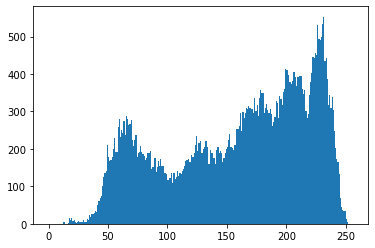

In [30]:
import matplotlib.pyplot as plt

img = food_images[20]
# Convert image to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Plot histogram of pixel intensity
plt.hist(img_gray.ravel(), bins=256, range=(0, 256))
plt.show()


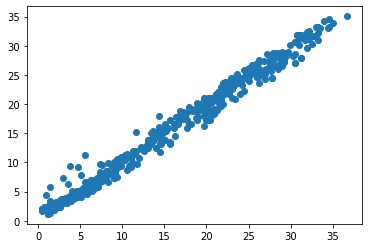

In [62]:
plt.scatter(img[1], img[2])
plt.show()

In [10]:
epochs = 10
for epoch in range(epochs):
    print('Epoch %d/%d' % (epoch+1, epochs))
    
    # Train the model on the training dataset
    train_loss = 0
    train_acc = 0
    train_steps = 0
    for x_batch_train, y_batch_train in train_dataset:
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        train_loss += loss_value.numpy()
        y_pred = np.argmax(logits.numpy(), axis=1)
        train_acc += np.mean(y_batch_train.numpy() == y_pred)
        train_steps += 1
    train_loss /= train_steps
    train_acc /= train_steps
    
    # Evaluate the model on the validation dataset
    val_loss = 0
    val_acc = 0
    val_steps = 0
    for x_batch_val, y_batch_val in val_dataset:
        logits = model(x_batch_val, training=False)
        loss_value = loss_fn(y_batch_val, logits)
        
        val_loss += loss_value.numpy()
        y_pred = np.argmax(logits.numpy(), axis=1)
        val_acc += np.mean(y_batch_val.numpy() == y_pred)
        val_steps += 1
    val_loss /= val_steps
    val_acc /= val_steps
    history.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc})
    # Print the training and validation loss and accuracy
    print('Train Loss: %.4f' % train_loss)
    print('Train Accuracy: %.4f' % train_acc)
    print('Val Loss: %.4f' % val_loss)
    print('Val Accuracy: %.4f' % val_acc)

# model on the testing dataset
test_loss = 0
test_acc = 0
test_steps = 0
for x_batch_test, y_batch_test in test_dataset:
    logits = model(x_batch_test, training=False)
    loss_value = loss_fn(y_batch_test, logits)

    test_loss += loss_value.numpy()
    y_pred = np.argmax(logits.numpy(), axis=1)
    test_acc += np.mean(y_batch_test.numpy() == y_pred)
    test_steps += 1
test_loss /= test_steps
test_acc /= test_steps

# testing loss and accuracy
print('Test Loss: %.4f' % test_loss)
print('Test Accuracy: %.4f' % test_acc)


Epoch 1/10
Train Loss: 1.4064
Train Accuracy: 0.7360
Val Loss: 0.5963
Val Accuracy: 0.8205
Epoch 2/10
Train Loss: 0.4616
Train Accuracy: 0.8381
Val Loss: 0.8366
Val Accuracy: 0.6915
Epoch 3/10
Train Loss: 0.3897
Train Accuracy: 0.8580
Val Loss: 0.3924
Val Accuracy: 0.8717
Epoch 4/10
Train Loss: 0.3419
Train Accuracy: 0.8787
Val Loss: 0.7626
Val Accuracy: 0.7580
Epoch 5/10
Train Loss: 0.3010
Train Accuracy: 0.8898
Val Loss: 1.0116
Val Accuracy: 0.7282
Epoch 6/10
Train Loss: 0.2737
Train Accuracy: 0.9017
Val Loss: 0.3988
Val Accuracy: 0.8891
Epoch 7/10
Train Loss: 0.2449
Train Accuracy: 0.9125
Val Loss: 0.3202
Val Accuracy: 0.9048
Epoch 8/10
Train Loss: 0.2220
Train Accuracy: 0.9189
Val Loss: 0.4187
Val Accuracy: 0.8647
Epoch 9/10
Train Loss: 0.2038
Train Accuracy: 0.9245
Val Loss: 0.2744
Val Accuracy: 0.9112
Epoch 10/10
Train Loss: 0.1861
Train Accuracy: 0.9319
Val Loss: 0.2786
Val Accuracy: 0.9111
Test Loss: 0.3100
Test Accuracy: 0.9018


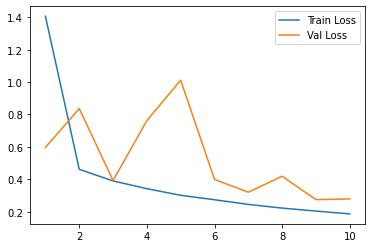

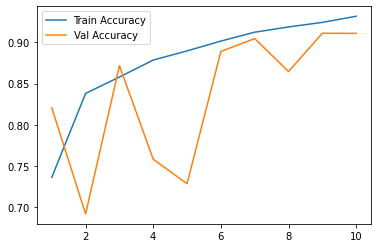

In [12]:
# Plot the training and validation loss and accuracy

plt.plot([h['epoch'] for h in history ],[ h['train_loss'] for h in history ], label='Train Loss')
plt.plot([h['epoch'] for h in history], [h['val_loss'] for h in history], label='Val Loss')
plt.legend()
plt.show()
plt.plot([h['epoch'] for h in history], [h['train_acc'] for h in history], label='Train Accuracy')
plt.plot([h['epoch'] for h in history], [ h['val_acc'] for h in history ], label='Val Accuracy')
plt.legend()
plt.show()



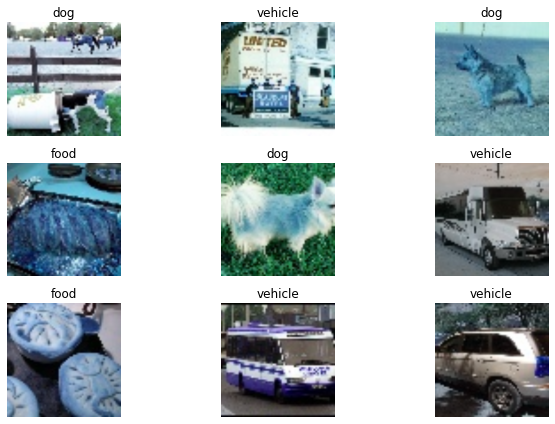

In [54]:
import matplotlib.pyplot as plt

# Define the classes
classes = ['food', 'dog', 'vehicle']

# Plot a sample of images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,6))
for i, ax in enumerate(axes.flat):
    img = X_train[i]
    label = classes[int(y_train[i])]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


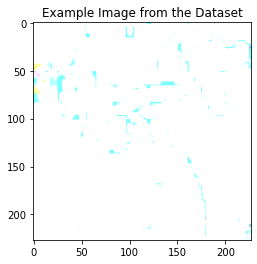

In [59]:
img = X[10]
img = np.transpose(img, (1, 0, 2)) 
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = img * std + mean 
plt.imshow(img)
plt.title('Example Image from the Dataset')
plt.show()


### References
1. https://medium.com/prathmesh-bhansali/exploring-svhn-using-deep-neural-network-1213959db92c
2. https://www.tensorflow.org/tutorials/load_data/images
3. https://www.tensorflow.org/tutorials/images/classification
4. https://github.com/eweill/keras-deepcv/blob/master/models/classification/alexnet.py
5. https://www.tensorflow.org/
6. https://keras.io/